In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from sklearn.linear_model import LinearRegression
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')

from train_nn_full import train_nn
from KS_solver import KS_step, ml_step

import torch

from jax_models import *

In [9]:
from torch import nn
import torch.nn.functional as F

In [10]:
def f_rand(L):
    nwaves = 5
    a = np.arange(nwaves)+1
    b = np.random.rand(nwaves)
    d = np.random.rand(nwaves)

    xi = np.linspace(0,L,1000)
    fx = xi*0
    for i in range(nwaves):
        fx = fx + b[i]*np.sin(2*a[i]*np.pi*(xi-d[i])/L)
        
    mina = np.min(fx)
    maxa = np.max(fx)

    def f(x):
        fx = x*0
        for i in range(nwaves):
            fx = fx + b[i]*np.sin(2*a[i]*np.pi*(x-d[i])/L)
            
        fx = (fx - mina) / (maxa - mina)   
        return fx

    return f

In [11]:
# define our KS domain and system
dt = 0.25
s = 128
l=22
M=16
KS = KuramotoSivashinsky(dt=dt, s=s, l=l, M=M)

In [46]:
class Model(nn.Module):
    def __init__(self, nx, hidden_dim):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.fc1 = nn.Linear(nx, 50).double()
        self.fc2 = nn.Linear(50,100).double()
        self.fc3 = nn.Linear(100,100).double()
        self.fc4 = nn.Linear(100, nx).double()
        self.act = nn.ReLU()
    
    def forward(self, u):
        uout = self.fc4(self.act(self.fc3(self.act(self.fc2(self.act(self.fc1(u)))))))
        
        return uout

def train_nn(KS, dt, nx, rollout,train_period, stencil, f_rand, print_mes=True, nb=5):
    L = KS.l
    x = np.arange(0,L, L/nx)

    # Instantiate the model with hyperparameters
    model = Model(nx, hidden_dim=100)


    t_weights = torch.tensor(np.arange(1,rollout+1)).unsqueeze(0)

    # Define hyperparameters
    n_epochs = 10000
    lr = 0.001

    # Define Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    T = rollout+stencil

    with torch.autograd.set_detect_anomaly(True):
    
        for epoch in range(0, n_epochs):
            optimizer.zero_grad()

            target_seq = np.zeros((nb, train_period+1, len(x)))
            for i in range(nb):
                f = f_rand(KS.l)
                target_seq[i,:,:] = KS_step(KS, train_period, f(x))    
            X = torch.tensor(target_seq[:,:-1].reshape(-1, target_seq.shape[2]))
            Y = torch.tensor(target_seq[:,1:].reshape(-1, target_seq.shape[2]))
            output = model(X)
            
            loss = torch.mean((Y-output)**2) # don't include IC
            print(epoch, 'loss: ', np.round(loss.detach().numpy(),6))
            loss.backward() # Does backpropagation and calculates gradients
            optimizer.step() # Updates the weights accordingly
            
    return model

In [47]:
rollout = 1
stencil = 50
nx = KS.s
train_period=300
model = train_nn(KS, dt, nx, rollout, train_period, stencil, f_rand, print_mes=True, nb=5)

0 loss:  1.469922
1 loss:  1.594399
2 loss:  1.388394
3 loss:  1.426571
4 loss:  1.418208
5 loss:  1.3223
6 loss:  1.406381
7 loss:  1.34234
8 loss:  1.204601
9 loss:  1.275642
10 loss:  1.220154
11 loss:  1.151658
12 loss:  1.305088
13 loss:  1.175073
14 loss:  1.055558
15 loss:  1.055972
16 loss:  1.063821
17 loss:  0.996717
18 loss:  1.025993
19 loss:  0.9896
20 loss:  0.925349
21 loss:  0.960042
22 loss:  0.904406
23 loss:  0.844509
24 loss:  0.803753
25 loss:  0.708774
26 loss:  0.721513
27 loss:  0.663339
28 loss:  0.665835
29 loss:  0.595212
30 loss:  0.605549
31 loss:  0.583159
32 loss:  0.597413
33 loss:  0.517069
34 loss:  0.517524
35 loss:  0.434909
36 loss:  0.42279
37 loss:  0.401029
38 loss:  0.374195
39 loss:  0.392247
40 loss:  0.37286
41 loss:  0.349615
42 loss:  0.328305
43 loss:  0.308675
44 loss:  0.301944
45 loss:  0.302508
46 loss:  0.270402
47 loss:  0.287255
48 loss:  0.259089
49 loss:  0.26409
50 loss:  0.222927
51 loss:  0.242328
52 loss:  0.237345
53 loss:  0

In [48]:
# inputted as dimensions (time, x)
def nn_step(model, y0, num_steps, all_steps=True):
    if len(y0.shape)==1:
        y0 = np.expand_dims(y0, 0)
    y_next = np.zeros((num_steps+1, y0.shape[1]))
    y_next[0,:] = y0
    y_next = torch.tensor(y_next)
    for i in range(1,num_steps+1):
        f_t = model(y_next[i-1,:])
        y_next[i,:] = f_t

    # transpose back to (time,x)
    y_next = y_next.detach().numpy()
    
    if all_steps:
        return y_next
    else:
        return y_next[-1]

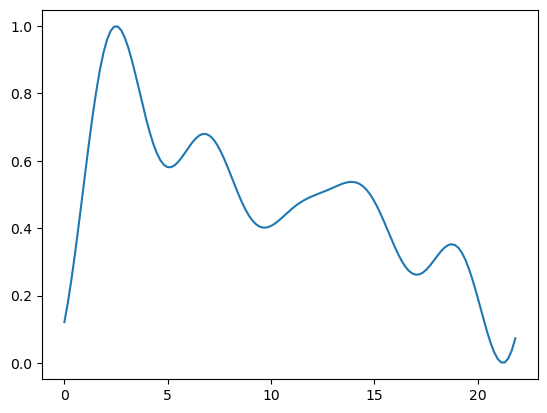

In [49]:
x = np.arange(0,l,l/s)
x_plot = np.linspace(0,l,s+1)
f = f_rand(l)
f0 = f(x)
plt.plot(x, f0)

(1, 128)


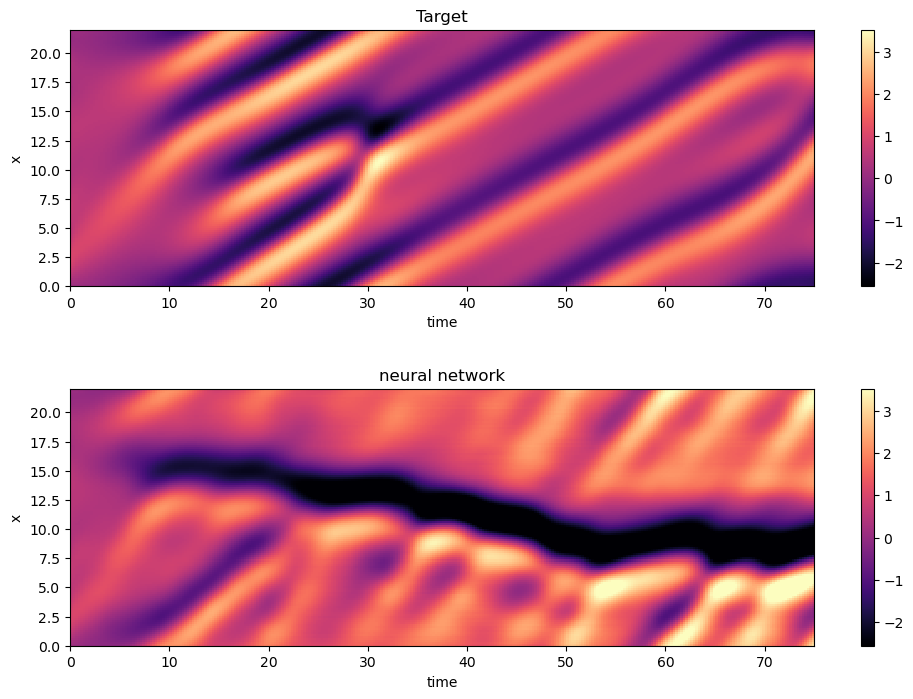

In [50]:
num_steps = 300
t = np.arange(0, KS.dt*(num_steps+1-0.1), KS.dt)

data_result = KS_step(KS, num_steps, f0)
y0 = data_result[0:1]
print(y0.shape)
nn_result = nn_step(model, y0, num_steps, all_steps=True)

vmax = np.max(data_result)
vmin = np.min(data_result)

fig, ax = plt.subplots(2,1, figsize=(12,8))

cm = ax[0].pcolormesh(t, x_plot, data_result[:-1].T, cmap='magma', vmax=vmax, vmin=vmin)
ax[0].set_xlabel('time')
ax[0].set_ylabel('x')
ax[0].set_title('Target')
plt.colorbar(cm, ax=ax[0])

ax[1].pcolormesh(t, x_plot, nn_result[:-1].T, cmap='magma', vmax=vmax, vmin=vmin)
ax[1].set_xlabel('time')
ax[1].set_ylabel('x')
ax[1].set_title('neural network')
plt.colorbar(cm, ax=ax[1])

plt.subplots_adjust(hspace=0.4)

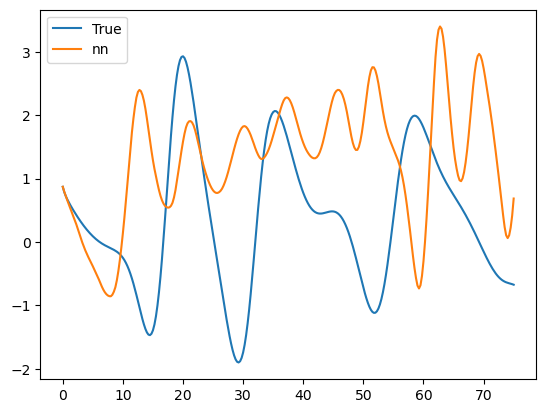

In [52]:
i=10
plt.plot(t, data_result[:,i], label='True')
plt.plot(t, nn_result[:,i], label='nn')
plt.legend()

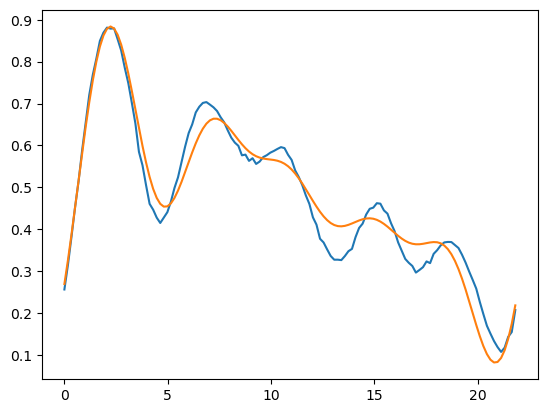

In [45]:
plt.plot(x, nn_result[2])
plt.plot(x, data_result[2])

In [37]:
nn_result.shape

(301, 128)